# NN

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier, KerasRegressor
import warnings
warnings.filterwarnings('ignore')

In [10]:
data = pd.read_csv('Kharovsklesprom_data.csv', index_col=0, parse_dates=['Date'])
data.head()

,Date,Time,Usage_kWh
0,2017-01-01,00 - 01,570.685479
1,2017-01-01,01 - 02,604.642705
2,2017-01-01,02 - 03,518.732113
3,2017-01-01,03 - 04,608.188829
4,2017-01-01,04 - 05,714.140572


In [11]:
data.head(), data.dtypes

(        Date     Time   Usage_kWh
 0 2017-01-01  00 - 01  570.685479
 1 2017-01-01  01 - 02  604.642705
 2 2017-01-01  02 - 03  518.732113
 3 2017-01-01  03 - 04  608.188829
 4 2017-01-01  04 - 05  714.140572,
 Date         datetime64[ns]
 Time                 object
 Usage_kWh           float64
 dtype: object)

In [12]:
data['DateTime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].str.slice(0, 2) + ':00:00')
data.set_index('DateTime', inplace=True)
data.drop(columns=['Date', 'Time'], inplace=True)

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

In [14]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return mape, mse, mae, r2

In [15]:
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back):
        a = data[i:(i+look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  
X, y = create_dataset(scaled_data, look_back)
X = X.reshape(X.shape[0], 1, X.shape[1])

# Наблюдение за раз

In [16]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

model.fit(X, y, epochs=2, batch_size=1, verbose=1)

Epoch 1/2
35063/35063 ━━━━━━━━━━━━━━━━━━━━ 26s 694us/step - loss: 0.0157
Epoch 2/2
35063/35063 ━━━━━━━━━━━━━━━━━━━━ 23s 656us/step - loss: 0.0149


In [17]:
test_points = X[-168:]  
predicted = model.predict(test_points)
predicted = scaler.inverse_transform(predicted)  

actual = scaler.inverse_transform(y[-168:].reshape(-1, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [18]:
hour_mape, hour_mse, hour_mae, hour_r2 = calculate_metrics(actual, predicted)

print("MAPE: {:.2f}%".format(hour_mape))
print("MSE: {:.2f}".format(hour_mse))
print("MAE: {:.2f}".format(hour_mae))
print("R2: {:.2f}".format(hour_r2))

MAPE: 19.26%
MSE: 41818.99
MAE: 158.94
R2: 0.64


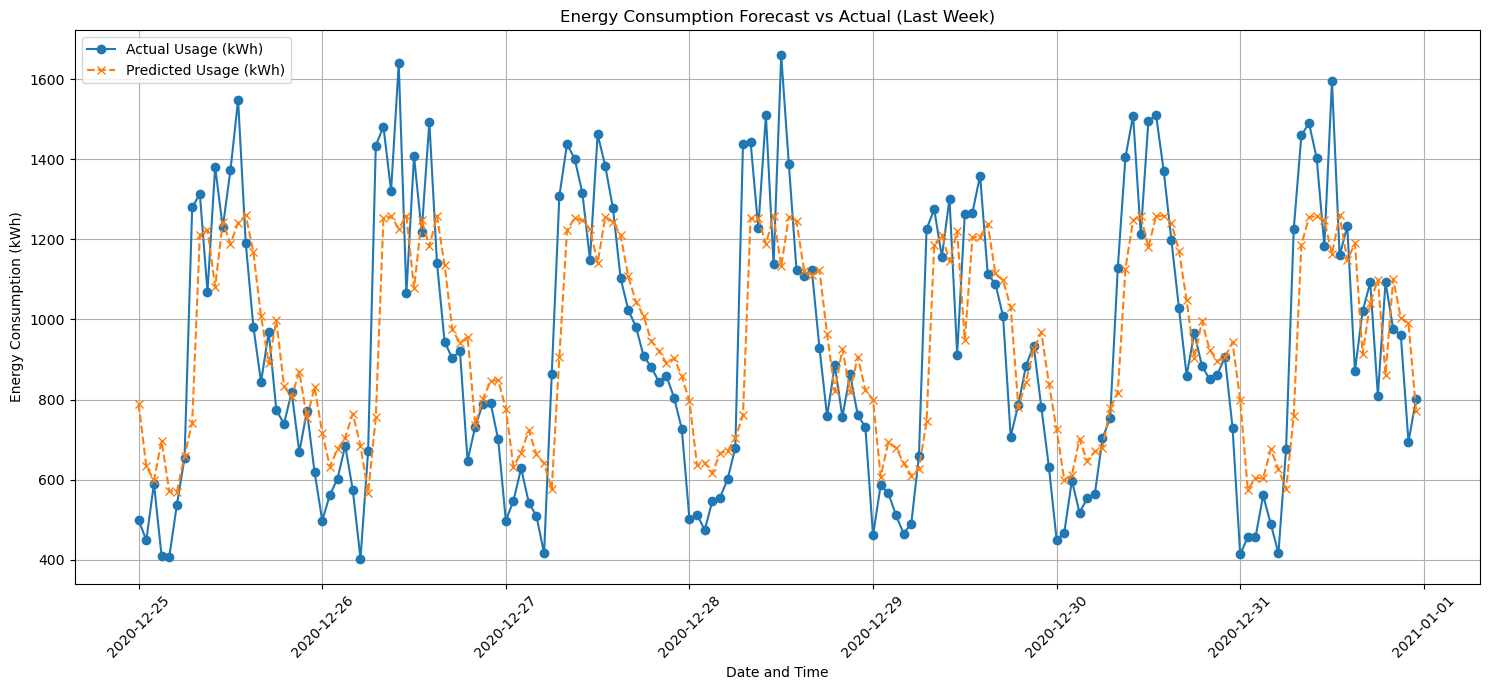

In [19]:
actual_last_week = actual[-168:].reshape(-1)
predicted_last_week = predicted.reshape(-168)

timestamps_last_week = data.index[-168:]

plt.figure(figsize=(15, 7))

plt.plot(timestamps_last_week, actual_last_week, label='Actual Usage (kWh)', marker='o', linestyle='-')

plt.plot(timestamps_last_week, predicted_last_week, label='Predicted Usage (kWh)', marker='x', linestyle='--')

plt.title('Energy Consumption Forecast vs Actual (Last Week)')
plt.xlabel('Date and Time')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Наблюдение за сутки

In [20]:
train_data = data.iloc[:-24*8]  
test_data = data.iloc[-24*8:]


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

In [21]:
def create_dataset(data, look_back=24):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


look_back = 24  
X_train, y_train = create_dataset(scaled_train_data, look_back)
X_test, y_test = create_dataset(scaled_test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], look_back, 1)
X_test = X_test.reshape(X_test.shape[0], look_back, 1)

model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

model.fit(X_train, y_train, epochs=2, batch_size=1, verbose=1)

daily_predict = model.predict(X_test)[-168:]  
daily_predict = scaler.inverse_transform(daily_predict)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))[-168:]

day_mape, day_mse, day_mae, day_r2 = calculate_metrics(actual, daily_predict)

print("\nTest Metrics:")
print("MAPE: {:.2f}%".format(day_mape))
print("MSE: {:.2f}".format(day_mse))
print("MAE: {:.2f}".format(day_mae))
print("R2: {:.2f}".format(day_r2))

Epoch 1/2
34848/34848 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - loss: 0.0114
Epoch 2/2
34848/34848 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - loss: 0.0074
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Test Metrics:
MAPE: 11.25%
MSE: 18876.69
MAE: 102.68
R2: 0.84


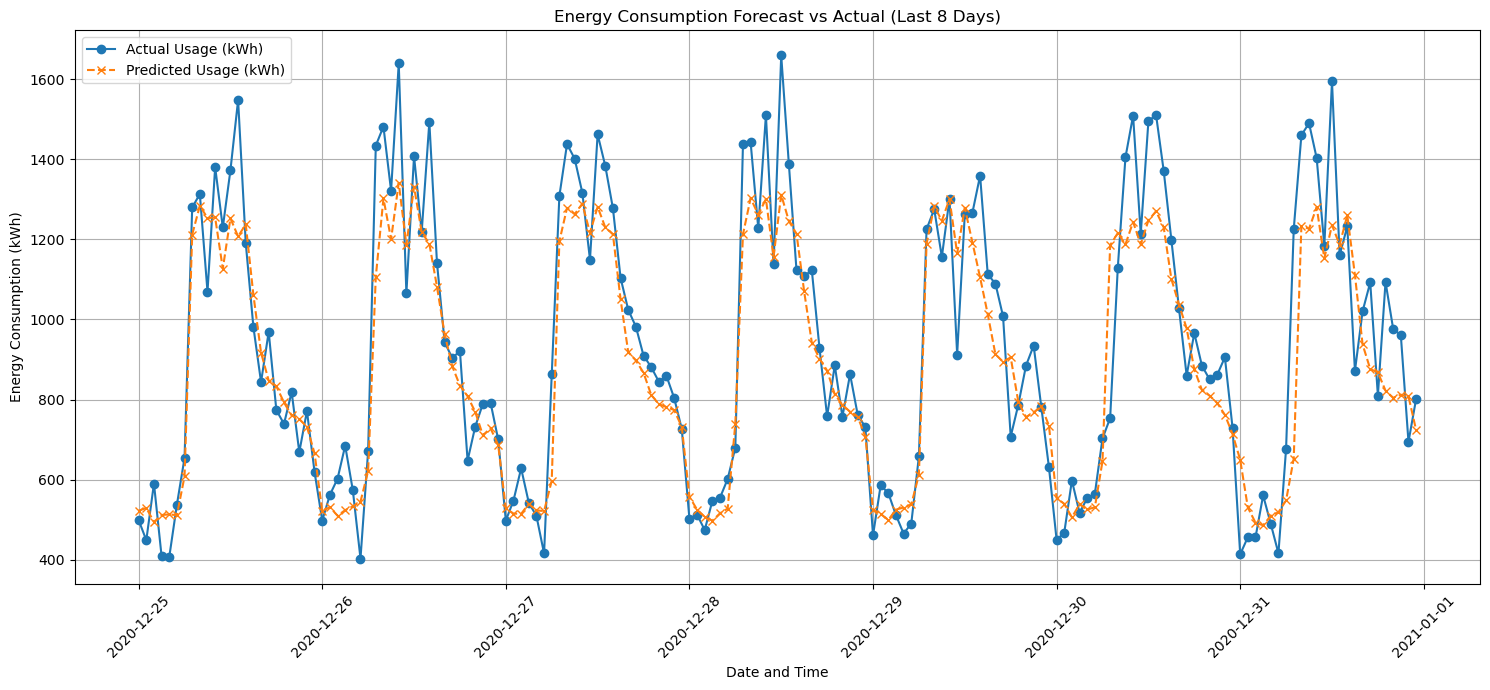

In [22]:
actual_last_8_days = actual[-168:]
predicted_last_8_days = daily_predict.reshape(-1)

timestamps_last_8_days = test_data.index[-168:]

plt.figure(figsize=(15, 7))

plt.plot(timestamps_last_8_days, actual_last_8_days, label='Actual Usage (kWh)', marker='o', linestyle='-')

plt.plot(timestamps_last_8_days, predicted_last_8_days, label='Predicted Usage (kWh)', marker='x', linestyle='--')

plt.title('Energy Consumption Forecast vs Actual (Last 8 Days)')
plt.xlabel('Date and Time')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Неделя за раз

In [23]:
def create_multistep_dataset(data, input_steps=168, future_steps=168):
    X, Y = [], []
    for i in range(len(data) - input_steps - future_steps):
        X.append(data[i:(i + input_steps), 0])
        Y.append(data[(i + input_steps):(i + input_steps + future_steps), 0])
    return np.array(X), np.array(Y)

input_steps = 168  
future_steps = 168  
X, y = create_multistep_dataset(scaled_data, input_steps, future_steps)
X = X.reshape(X.shape[0], 1, X.shape[1])
y = y.reshape(y.shape[0], 1, y.shape[1])

In [24]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, input_steps), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(future_steps))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

model.fit(X, y, epochs=2, batch_size=1, verbose=1)

Epoch 1/2
34728/34728 ━━━━━━━━━━━━━━━━━━━━ 33s 894us/step - loss: 0.0090
Epoch 2/2
34728/34728 ━━━━━━━━━━━━━━━━━━━━ 30s 876us/step - loss: 0.0069


In [25]:
last_week_data = scaled_data[-input_steps:].reshape(1, 1, input_steps)
predicted_next_week = model.predict(last_week_data)
predicted_next_week = scaler.inverse_transform(predicted_next_week.reshape(-1, 1))

actual_next_week = data['Usage_kWh'][-future_steps:].values

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


In [26]:
week_mape, week_mse, week_mae, week_r2 = calculate_metrics(actual_next_week, predicted_next_week)

print("Metrics:")
print("MAPE: {:.2f}%".format(week_mape))
print("MSE: {:.2f}".format(week_mse))
print("MAE: {:.2f}".format(week_mae))
print("R2: {:.2f}".format(week_r2))

Metrics:
MAPE: 45.22%
MSE: 16222.61
MAE: 99.03
R2: 0.86


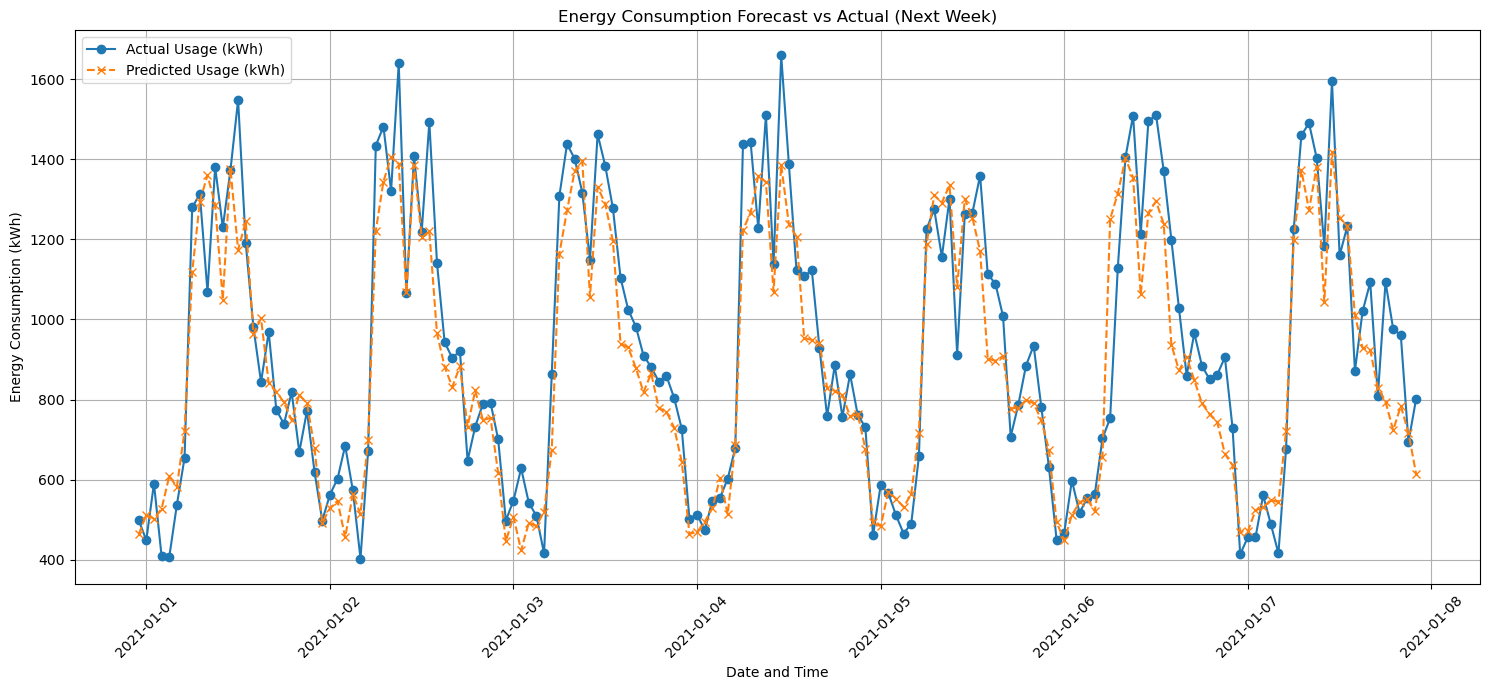

In [27]:
next_week_index = pd.date_range(start=data.index[-1], periods=future_steps, freq='H')

plt.figure(figsize=(15, 7))

plt.plot(next_week_index, actual_next_week, label='Actual Usage (kWh)', marker='o', linestyle='-')

plt.plot(next_week_index, predicted_next_week, label='Predicted Usage (kWh)', marker='x', linestyle='--')

plt.title('Energy Consumption Forecast vs Actual (Next Week)')
plt.xlabel('Date and Time')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Визуализация

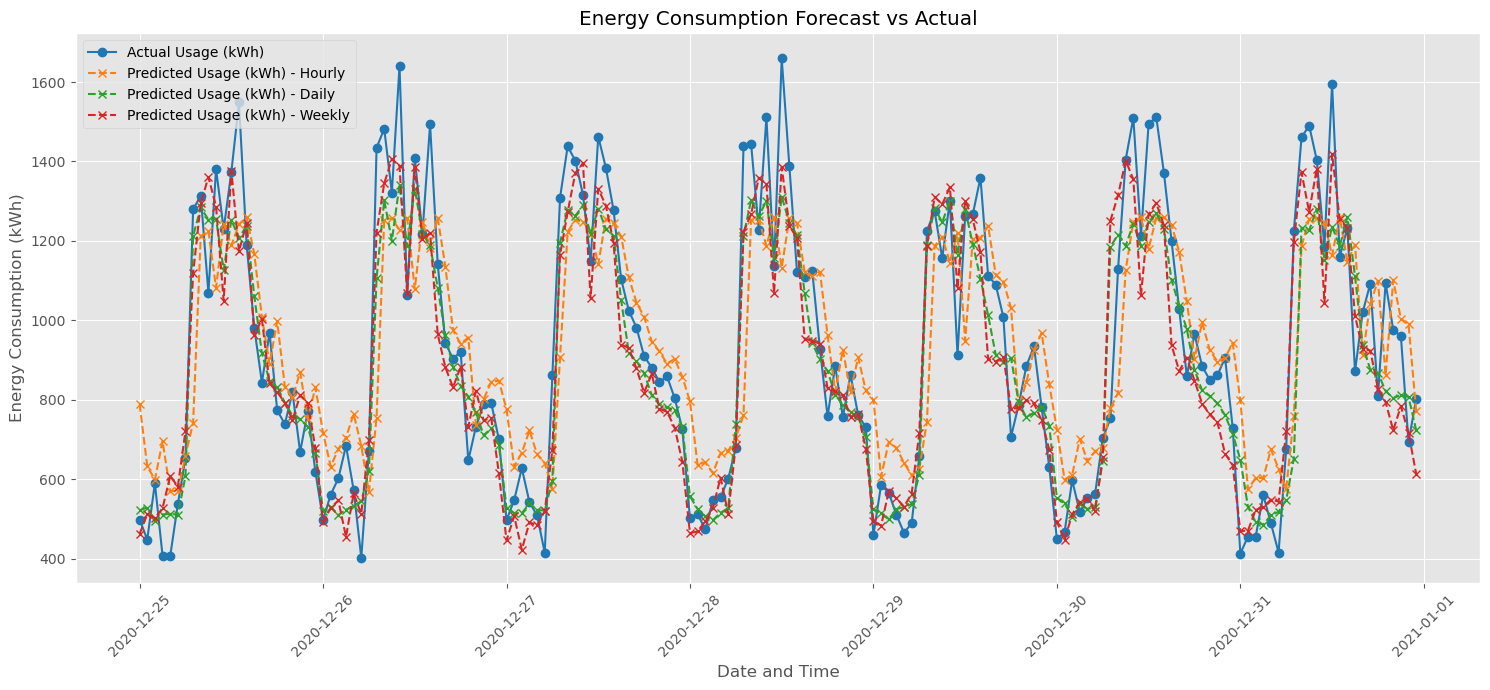

In [28]:
end_date = pd.to_datetime('2020-12-31 23:00:00')

plt.style.use('ggplot')

timestamps_hourly = pd.date_range(start=end_date - pd.Timedelta(hours=167), end=end_date, freq='H')

plt.figure(figsize=(15, 7))
plt.plot(timestamps_hourly, actual, label='Actual Usage (kWh)', marker='o', linestyle='-', color='tab:blue')
plt.plot(timestamps_hourly, predicted, label='Predicted Usage (kWh) - Hourly', marker='x', linestyle='--', color='tab:orange')

daily_index = timestamps_hourly[-169:]
plt.plot(daily_index, daily_predict, label='Predicted Usage (kWh) - Daily', marker='x', linestyle='--', color='tab:green')

plt.plot(timestamps_hourly, predicted_next_week, label='Predicted Usage (kWh) - Weekly', marker='x', linestyle='--', color='tab:red')

plt.title('Energy Consumption Forecast vs Actual')
plt.xlabel('Date and Time')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


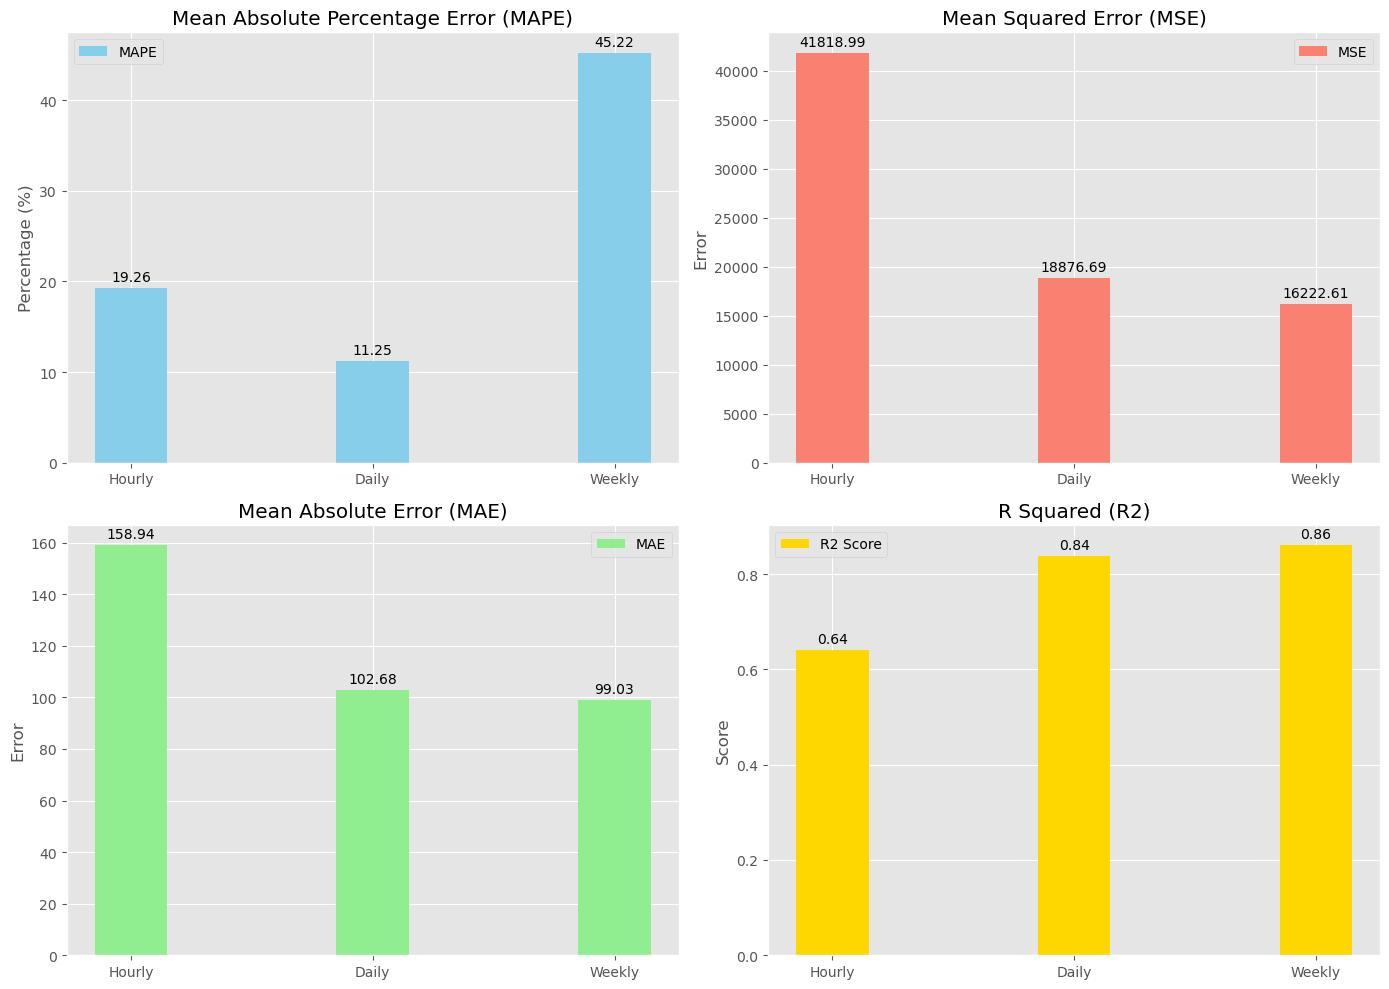

In [31]:
mape_values = [hour_mape, day_mape, week_mape]
mse_values = [hour_mse, day_mse, week_mse]
mae_values = [hour_mae, day_mae, week_mae]
r2_values = [hour_r2, day_r2, week_r2]

forecast_variants = ['Hourly', 'Daily', 'Weekly']

plt.style.use('ggplot')

bar_width = 0.3
index = np.arange(len(forecast_variants))

def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

bars = axs[0, 0].bar(index, mape_values, bar_width, color='skyblue', label='MAPE')
add_labels(axs[0, 0], bars)
axs[0, 0].set_title('Mean Absolute Percentage Error (MAPE)')
axs[0, 0].set_xticks(index)
axs[0, 0].set_xticklabels(forecast_variants)
axs[0, 0].set_ylabel('Percentage (%)')

bars = axs[0, 1].bar(index, mse_values, bar_width, color='salmon', label='MSE')
add_labels(axs[0, 1], bars)
axs[0, 1].set_title('Mean Squared Error (MSE)')
axs[0, 1].set_xticks(index)
axs[0, 1].set_xticklabels(forecast_variants)
axs[0, 1].set_ylabel('Error')

bars = axs[1, 0].bar(index, mae_values, bar_width, color='lightgreen', label='MAE')
add_labels(axs[1, 0], bars)
axs[1, 0].set_title('Mean Absolute Error (MAE)')
axs[1, 0].set_xticks(index)
axs[1, 0].set_xticklabels(forecast_variants)
axs[1, 0].set_ylabel('Error')

bars = axs[1, 1].bar(index, r2_values, bar_width, color='gold', label='R2 Score')
add_labels(axs[1, 1], bars)
axs[1, 1].set_title('R Squared (R2)')
axs[1, 1].set_xticks(index)
axs[1, 1].set_xticklabels(forecast_variants)
axs[1, 1].set_ylabel('Score')

for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()